In [27]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
from torch import nn
from torch.utils.data import DataLoader, Dataset
import os
import zipfile
from tqdm import tqdm

In [28]:
torch.cuda.is_available()
torch.__version__

'2.3.1+cu121'

In [29]:
# 解压缩
zip_path=r"data.zip"
with zipfile.ZipFile(zip_path,"r") as file:
    file.extractall()
print("zip解压完成")

zip解压完成


In [30]:
train=pd.read_csv("./data/train.csv",parse_dates=["date"])
test=pd.read_csv("./data/test.csv",parse_dates=["date"])
sub=pd.read_csv("./data/sample_submission.csv")
oil=pd.read_csv("./data/oil.csv",parse_dates=["date"])

print("train shape:",train.shape)
display(train.head())

print("\ntest shape:",test.shape)
display(test.head())

print("\noil shape:",oil.shape)
display(oil.head())

train shape: (3000888, 6)


,id,date,store_nbr,family,sales,onpromotion
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0
1,1,2013-01-01,1,BABY CARE,0.0,0
2,2,2013-01-01,1,BEAUTY,0.0,0
3,3,2013-01-01,1,BEVERAGES,0.0,0
4,4,2013-01-01,1,BOOKS,0.0,0



test shape: (28512, 5)


,id,date,store_nbr,family,onpromotion
0,3000888,2017-08-16,1,AUTOMOTIVE,0
1,3000889,2017-08-16,1,BABY CARE,0
2,3000890,2017-08-16,1,BEAUTY,2
3,3000891,2017-08-16,1,BEVERAGES,20
4,3000892,2017-08-16,1,BOOKS,0



oil shape: (1218, 2)


,date,dcoilwtico
0,2013-01-01,NaN
1,2013-01-02,93.14
2,2013-01-03,92.97
3,2013-01-04,93.12
4,2013-01-07,93.20


In [31]:
# 查看各个数据的基本信息
print("train info:")
train.info()

print("\n\ntest info:")
test.info()

print("\n\noil info:")
oil.info()


train info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000888 entries, 0 to 3000887
Data columns (total 6 columns):
 #   Column       Dtype         
---  ------       -----         
 0   id           int64         
 1   date         datetime64[ns]
 2   store_nbr    int64         
 3   family       object        
 4   sales        float64       
 5   onpromotion  int64         
dtypes: datetime64[ns](1), float64(1), int64(3), object(1)
memory usage: 137.4+ MB


test info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28512 entries, 0 to 28511
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   id           28512 non-null  int64         
 1   date         28512 non-null  datetime64[ns]
 2   store_nbr    28512 non-null  int64         
 3   family       28512 non-null  object        
 4   onpromotion  28512 non-null  int64         
dtypes: datetime64[ns](1), int64(3), object(1)
memory usage: 1.1+

In [32]:
def dispaly_missing_data(df):
    CATS,NUM=[],[]
    for col in df.columns:
        if df[col].dtype=="object":
            CATS.append(col)
            print(f"{col:15}[CAT]{df[col].nunique():-20}unique{df[col].isna().sum():10}NAN")
        else:
            NUM.append(col)
            print(f"{col:15}[NUM]{df[col].nunique():-20}unique{df[col].isna().sum():10}NAN")

    print("CATS:",CATS)
    print("NUM:",NUM)  
    return CATS,NUM 


In [33]:
print("\ntrain")
dispaly_missing_data(train)

print("\ntest")
dispaly_missing_data(test)

print("\noil")
dispaly_missing_data(oil)


train
id             [NUM]             3000888unique         0NAN
date           [NUM]                1684unique         0NAN
store_nbr      [NUM]                  54unique         0NAN
family         [CAT]                  33unique         0NAN
sales          [NUM]              379610unique         0NAN
onpromotion    [NUM]                 362unique         0NAN
CATS: ['family']
NUM: ['id', 'date', 'store_nbr', 'sales', 'onpromotion']

test
id             [NUM]               28512unique         0NAN
date           [NUM]                  16unique         0NAN
store_nbr      [NUM]                  54unique         0NAN
family         [CAT]                  33unique         0NAN
onpromotion    [NUM]                 212unique         0NAN
CATS: ['family']
NUM: ['id', 'date', 'store_nbr', 'onpromotion']

oil
date           [NUM]                1218unique         0NAN
dcoilwtico     [NUM]                 998unique        43NAN
CATS: []
NUM: ['date', 'dcoilwtico']


([], ['date', 'dcoilwtico'])

<Axes: title={'center': 'Oil Price'}, xlabel='date', ylabel='dcoilwtico'>

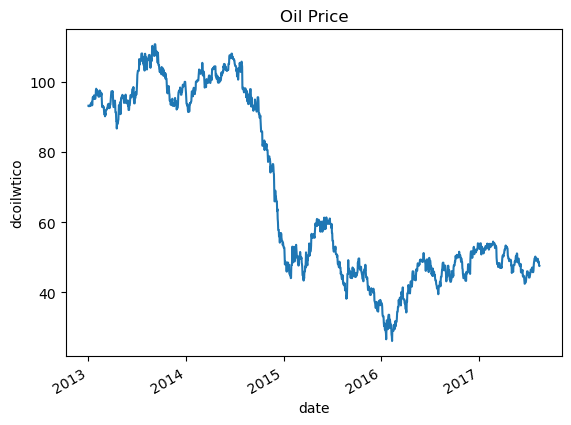

In [34]:
oil_price=oil.set_index("date")["dcoilwtico"].interpolate()
oil_price=oil_price.reindex(pd.to_datetime(train["date"]).unique()).ffill().bfill()
oil_price.plot(title="Oil Price",ylabel="dcoilwtico",xlabel="date")

In [35]:
from sklearn.preprocessing import LabelEncoder
train["item_ID"]=train["store_nbr"].astype(str)+"_"+train["family"]
test["item_ID"]=test["store_nbr"].astype(str)+"_"+test["family"]
pre=LabelEncoder()
train["item_enc"]=pre.fit_transform(train["item_ID"])
test["item_enc"]=pre.transform(test["item_ID"])

pre=LabelEncoder()
train["family"]=pre.fit_transform(train["family"])
test["family"]=pre.transform(test["family"])

print(f"Created {train['item_enc'].nunique()} features")

Created 1782 features


In [36]:
def create_time_features(df):
    df=df.copy()
    df["day_of_week"]=df["date"].dt.dayofweek+1
    df["month"]=df["date"].dt.month
    df["day"]=df["date"].dt.day
    df=df.merge(oil_price.reset_index(),on="date",how="left")
    df["is_weekend"]=df["day_of_week"].isin([6,7]).astype(int)
    df["promotion"]=df["onpromotion"].astype(int)
    
    return df

train=create_time_features(train)
test=create_time_features(test)

In [37]:
train.head()

,id,date,store_nbr,family,sales,onpromotion,item_ID,item_enc,day_of_week,month,day,dcoilwtico,is_weekend,promotion
0,0,2013-01-01,1,0,0.0,0,1_AUTOMOTIVE,330,2,1,1,93.14,0,0
1,1,2013-01-01,1,1,0.0,0,1_BABY CARE,331,2,1,1,93.14,0,0
2,2,2013-01-01,1,2,0.0,0,1_BEAUTY,332,2,1,1,93.14,0,0
3,3,2013-01-01,1,3,0.0,0,1_BEVERAGES,333,2,1,1,93.14,0,0
4,4,2013-01-01,1,4,0.0,0,1_BOOKS,334,2,1,1,93.14,0,0


In [38]:
train=train.drop(columns=["id","item_ID"])
test=test.drop(columns=["id","item_ID"])

train.head()

,date,store_nbr,family,sales,onpromotion,item_enc,day_of_week,month,day,dcoilwtico,is_weekend,promotion
0,2013-01-01,1,0,0.0,0,330,2,1,1,93.14,0,0
1,2013-01-01,1,1,0.0,0,331,2,1,1,93.14,0,0
2,2013-01-01,1,2,0.0,0,332,2,1,1,93.14,0,0
3,2013-01-01,1,3,0.0,0,333,2,1,1,93.14,0,0
4,2013-01-01,1,4,0.0,0,334,2,1,1,93.14,0,0


In [39]:
# 从下表可以看出，每一类别训练数据有1684个时间步，测试数据侧有16个时间步（这也是我们需要预测的）
# 在这里，我们取 train_step=90,test_step=16

train.groupby(["item_enc"])["date"].size().reset_index(), test.groupby(["item_enc"])["date"].size().reset_index()

(      item_enc  date
 0            0  1684
 1            1  1684
 2            2  1684
 3            3  1684
 4            4  1684
 ...        ...   ...
 1777      1777  1684
 1778      1778  1684
 1779      1779  1684
 1780      1780  1684
 1781      1781  1684
 
 [1782 rows x 2 columns],
       item_enc  date
 0            0    16
 1            1    16
 2            2    16
 3            3    16
 4            4    16
 ...        ...   ...
 1777      1777    16
 1778      1778    16
 1779      1779    16
 1780      1780    16
 1781      1781    16
 
 [1782 rows x 2 columns])

In [40]:
print("\ntrain")
dispaly_missing_data(train)

print("\ntest")
dispaly_missing_data(test)


train
date           [NUM]                1684unique         0NAN
store_nbr      [NUM]                  54unique         0NAN
family         [NUM]                  33unique         0NAN
sales          [NUM]              379610unique         0NAN
onpromotion    [NUM]                 362unique         0NAN
item_enc       [NUM]                1782unique         0NAN
day_of_week    [NUM]                   7unique         0NAN
month          [NUM]                  12unique         0NAN
day            [NUM]                  31unique         0NAN
dcoilwtico     [NUM]                1029unique         0NAN
is_weekend     [NUM]                   2unique         0NAN
promotion      [NUM]                 362unique         0NAN
CATS: []
NUM: ['date', 'store_nbr', 'family', 'sales', 'onpromotion', 'item_enc', 'day_of_week', 'month', 'day', 'dcoilwtico', 'is_weekend', 'promotion']

test
date           [NUM]                  16unique         0NAN
store_nbr      [NUM]                  54unique       

([],
 ['date',
  'store_nbr',
  'family',
  'onpromotion',
  'item_enc',
  'day_of_week',
  'month',
  'day',
  'dcoilwtico',
  'is_weekend',
  'promotion'])

In [118]:
import random

CAT,NUM=["item_enc"],["family","store_nbr","day_of_week","dcoilwtico","month","day","is_weekend","promotion"]

class SalesDataset(Dataset):
    def __init__(self,df,enc_len=90,pred_len=16,windows=120,val_size=0.2,mode="train"):
        self.mode=mode
        self.enc_len=enc_len
        self.pred_len=pred_len
        self.windows=windows if mode=="train" else 1

        df=df.sort_values(["item_enc","date"]).reset_index(drop=True)
        self.data=[]
        for _,group in df.groupby("item_enc"):
            num=group[NUM].values.astype(np.float32)
            cat=group[CAT].values.astype(np.int64)
            sales=group["sales"].values.astype(np.float32)

            L=len(sales)
            # 最大合法窗口起始点
            max_start=L-enc_len-pred_len
            if mode =="train" or mode=="val":
                # 只取最近的窗口
                starts=range(max(0,max_start-windows+1),max_start+1)
            elif mode=="test":
                starts=[L-enc_len]
            else:
                raise NameError
            for start in starts:
                y=sales[start+enc_len:start+enc_len+pred_len]
                self.data.append({
                    "num":num[start:start+enc_len],
                    "cat":cat[start:start+enc_len],
                    "y":y if len(y) else np.ones(pred_len), # 测试数据，对应的 y=[]
                    # temp=[1,2,3,4]  temp[4:4+16]=[]
                })
        # self.data固定
        if mode=="train" :
            random.seed(42)
            random.shuffle(self.data)
            self.data=self.data[int(len(self.data)*val_size):]
        elif mode=="val":
            random.seed(42)
            random.shuffle(self.data)
            self.data=self.data[:int(len(self.data)*val_size)]
            
    def __len__(self):
        return len(self.data)

    def __getitem__(self,idx):
        # 继承自torch的 Dataset ,强制要求每次传入一个idx，最后进行堆叠
        item=self.data[idx]
        return {
            "encoder_num":torch.tensor(item["num"],dtype=torch.float32),
            "encoder_cat":torch.tensor(item["cat"],dtype=torch.long),
            "y":torch.tensor(item["y"],dtype=torch.float32)
        }

In [145]:
configue={
    "batch_size":128,
    "epochs":20,
    "device":"cuda" if torch.cuda.is_available() else "cpu"
}

In [109]:
class logloss(nn.MSELoss):
    def __init__(self,eps=1e-6,**kwargs):
        super().__init__(**kwargs)
        self.eps=eps
    def forward(self,y,pred):
        pred=torch.clamp(pred,min=0)
        y,pred=torch.log1p(y),torch.log1p(pred)

        return torch.sqrt(torch.mean((y-pred)**2))

In [110]:
class Accumulator:
    def __init__(self,num):
        self.metric=[0]*num
    def __getitem__(self,idx):
        return self.metric[idx]
    def add(self,*args):
        if args:
            for i,arg in enumerate(args):
                self.metric[i]+=arg

class Recorder:
    def __init__(self,num):
        self.metric=[[] for _ in range(num)]
    def __getitem__(self,idx):
        return self.metric[idx]
    def __len__(self):
        return len(self.metric)
    def add(self,*args):
        if args:
            for i,arg in enumerate(args):
                self.metric[i].append(arg)

# 基于LSTM的训练

In [111]:
class LSTM(nn.Module):
    def __init__(self,num_features=len(NUM),embed_dim=16,hidden_size=128,num_layers=2,dropout=0.2):
        super().__init__()

        #压缩序列标签
        self.embed_series=nn.Embedding(1782,embed_dim)
        # 数据特征投影
        self.num_features=nn.Linear(num_features,hidden_size)

        # LSTM
        self.LSTM=nn.LSTM(input_size=hidden_size+embed_dim,
                         hidden_size=hidden_size,
                         num_layers=num_layers,
                         batch_first=True)
        self.dropout=nn.Dropout(dropout)
        self.head=nn.Sequential(
            nn.Linear(hidden_size,64),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Dropout(dropout),

            nn.Linear(64,16),
        )

    def forward(self,encoder_num,encoder_cat):
        """
        encoder_num shape :(batch,90,len(NUM))
        encoder_cat shape :(batch,90,1)
        """
        encoder_num=self.num_features(encoder_num)
        encoder_cat=self.embed_series(encoder_cat.squeeze(-1))
        x=torch.cat([encoder_cat,encoder_num],dim=-1)

        out,_=self.LSTM(x)
        out=self.dropout(out)
        pred=self.head(out[:,-1,:])

        # out shape :(batch,16)
        return pred

In [112]:
@torch.no_grad
def predict(net,data_iter,device,criterion):
    net.eval()
    net=net.to(device)
    metric=Accumulator(2)
    record=Recorder(1)
    for batch in data_iter:
        pred=net(batch["encoder_num"].to(device),batch["encoder_cat"].to(device))
        loss=criterion(batch["y"].to(device),pred)
        metric.add(loss.cpu().item()*len(pred),len(pred))
        record.add(pred.cpu())
    loss=metric[0]/metric[1]
    pred=torch.cat(record[0],dim=0)
    net.train()
    # return (loss,pred)
    return loss, pred

In [146]:
train_iter=DataLoader(SalesDataset(train,mode="train"),batch_size=configue["batch_size"],shuffle=True)
test_iter=DataLoader(SalesDataset(train,mode="test"),batch_size=configue["batch_size"],shuffle=False)
val_iter=DataLoader(SalesDataset(train,mode="val"),batch_size=configue["batch_size"],shuffle=False)

device=configue["device"]
net=LSTM(embed_dim=32,num_layers=4).to(device)
optim=torch.optim.AdamW(net.parameters(),lr=1e-3,weight_decay=1e-4)
scheduler=torch.optim.lr_scheduler.ReduceLROnPlateau(mode="min",optimizer=optim,patience=2,factor=0.3)
criterion=logloss()
# <training>
pbar=tqdm(total=configue['epochs'],desc="<training>")
epoch_metric=Recorder(2)

print("training...")
for epoch in range(configue["epochs"]):
    batch_metric=Accumulator(2)
    for x in train_iter:
        y_true=x["y"].to(device)
        optim.zero_grad()
        y_pred=net(x["encoder_num"].to(device),x["encoder_cat"].to(device))
        loss=criterion(y_true,y_pred)
        loss.backward()
        optim.step()

        batch_metric.add(loss.cpu().item()*len(y_true),len(y_true))
    # predicting
    val_loss,_=predict(net,val_iter,device,criterion)
    scheduler.step(val_loss)
    
    pbar.update(1)
    pbar.set_description(f"<train loss>{batch_metric[0]/batch_metric[1]}     <val loss>{val_loss}")
    epoch_metric.add(batch_metric[0]/batch_metric[1],val_loss)
pbar.close()

<training>:   0%|                                                                               | 0/20 [00:00<?, ?it/s]

training...


<train loss>0.502273964571944     <val loss>0.4651582045721018: 100%|█████████████████| 20/20 [54:38<00:00, 163.93s/it]


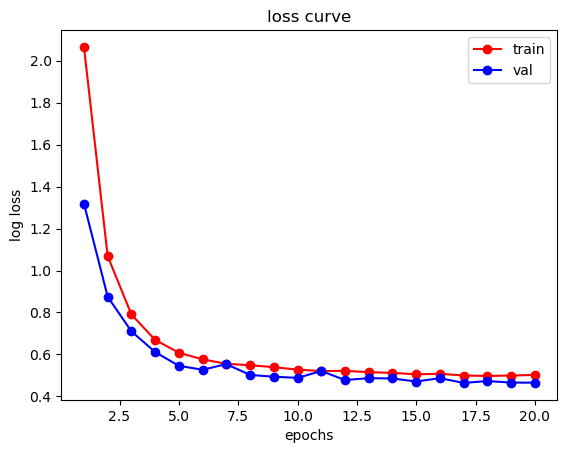

In [148]:
plt.plot(range(1,len(epoch_metric[0])+1),epoch_metric[0],"r-o",label="train")
plt.plot(range(1,len(epoch_metric[1])+1),epoch_metric[1],"b-o",label="val")
plt.title("loss curve")
plt.xlabel("epochs")
plt.ylabel("log loss")
plt.legend()
plt.savefig("LSTM'loss curve")
plt.show()

In [149]:
test_iter=DataLoader(SalesDataset(train,mode="test"),batch_size=configue["batch_size"],shuffle=False)

print("predicting ...")
_,pred=predict(net,test_iter,device,criterion)
print(pred.shape)

predicting ...
torch.Size([1782, 16])


In [150]:
# 反演
test_temp=test.sort_values(["item_enc","date"])
index=test_temp.index

sub_temp=sub.iloc[index]
sub_temp["sales"]=pred.flatten().tolist()
sub_temp=sub_temp.sort_index()    # 默认按行索引排序
sub_temp.to_csv("./data/submission_v1.csv",index=False)

# 基于Transformer的训练

In [161]:
# 采用混合精度训练
import torch.cuda.amp as amp

In [160]:
configue={
    "batch_size":256,
    "epochs":20,
    "device":"cuda",
    "lr":3e-4,
    "mixed_precision":True,
    "device":"cuda" if torch.cuda.is_available() else "cpu",
    "num_workers":4
}
torch.backends.cudnn.benchmark=True
torch.backends.cuda.matmul.allow_tf32=True
torch.backends.cudnn.allow_tf32=True

In [164]:
class Transformer(nn.Module):
    def __init__(self,num_features=len(NUM),embed_dim=48,hidden_size=192,\
                        num_layers=4,num_heads=8,dropout=0.2):
        super().__init__()
        self.embedding=nn.Embedding(1782,embed_dim)
        self.num_features=nn.Linear(num_features,hidden_size)
        # 可学习的位置编码矩阵
        self.pos_encoding=nn.Parameter(torch.randn(1,90,hidden_size+embed_dim))
        encoder_layer=nn.TransformerEncoderLayer(
            # d_model必须能被 num_heads 整除，这是torch多头注意力强制要求的。
            d_model=hidden_size+embed_dim,
            nhead=num_heads,
            dim_feedforward=hidden_size*3,
            dropout=dropout,
            batch_first=True,
            activation="gelu",
            norm_first=True
        )
        self.transformer=nn.TransformerEncoder(encoder_layer,num_layers)
        # 输出头
        self.head=nn.Sequential(
            nn.Linear(hidden_size+embed_dim,96),
            nn.BatchNorm1d(96),
            nn.GELU(),
            nn.Dropout(dropout),
            
            nn.Linear(96,48),
            nn.BatchNorm1d(48),
            nn.GELU(),
            nn.Dropout(dropout),

            nn.Linear(48,16)
        )

    def forward(self,encoder_num,encoder_cat):
        
        num_features=self.num_features(encoder_num)
        cat_features=self.embedding(encoder_cat)
        x=torch.cat([num_features,cat_features],dim=-1)
        x=x+self.pos_encoding[:,:x.size(1),:]
        out=self.transformer(x)
        out=out[:,-1,:]

        pred=self.head(out)
        return pred

In [165]:
@torch.no_grad
def predict(net,data_iter,device,criterion):
    net.eval()
    net=net.to(device)
    metric=Accumulator(2)
    record=Recorder(1)
    for batch in data_iter:
        pred=net(batch["encoder_num"].to(device,non_blocking=True),batch["encoder_cat"].to(device,non_blocking=True))
        loss=criterion(batch["y"].to(device),pred)
        metric.add(loss.cpu().item()*len(pred),len(pred))
        record.add(pred.cpu())
    loss=metric[0]/metric[1]
    pred=torch.cat(record[0],dim=0)
    net.train()
    # return (loss,pred)
    return loss, pred

In [ ]:
train_iter=DataLoader(SalesDataset(train,mode="train"),batch_size=configue["batch_size"],\
                      shuffle=True,pin_memory=True,num_workers=configue["num_workers"])
test_iter=DataLoader(SalesDataset(train,mode="test"),batch_size=configue["batch_size"],\
                     shuffle=False,pin_memory=True,num_workers=configue["num_workers"])
val_iter=DataLoader(SalesDataset(train,mode="val"),batch_size=configue["batch_size"],\
                    shuffle=False,pin_memory=True,num_workers=configue["num_workers"])

device=configue["device"]
net=Transformer().to(device)
optim=torch.optim.AdamW(net.parameters(),configue["lr"],weight_decay=0.01)
scheduler=torch.optim.lr_scheduler.OneCycleLR(optim,max_lr=configue['lr'],epochs=configue["epochs"],\
                                             steps_per_epoch=len(train_iter),pct_start=0.1)
criterion=logloss()
# 防止 float16 下梯度为0
scaler=amp.GradScaler(enabled=configue["mixed_precision"])

# <training>
pbar=tqdm(total=configue['epochs'],desc="<training>")
epoch_metric=Recorder(2)

print("training...")
for epoch in range(configue["epochs"]):
    batch_metric=Accumulator(2)
    for x in train_iter:
        y_true=x["y"].to(device,non_blocking=True)  # 异步拷贝，不阻塞进程,配合 pin_memory使用，DMA转运🫣
        optim.zero_grad()
        # 混合精度的前向传播
        with amp.autocast(enabled=configue["mixed_precision"]):
            y_pred=net(x["encoder_num"].to(device,non_blocking=True),x["encoder_cat"].to(device,non_blocking=True))
            loss=criterion(y_true,y_pred)
        # 混合精度的反向传播
        scaler.scale(loss).backward()
        scaler.unscale_(optim)# 取消缩放
        # 梯度裁剪
        nn.utils.clip_grad_norm_(net.parameters(),1.0)
        # 更新
        scaler.step(optim) # 当本次梯度没有 inf 或者 NAN才会选择更新，否则跳过本次
        scaler.update()
        #FP16 的问题：精度低 → 很小的梯度可能下溢（变 0）, 很大梯度可能溢出（变 inf / nan）     
                            # 所以我们用 GradScaler 做动态损失缩放,即放大损失,但是放大倍数太大和太小都会发生上述的情况,所以我们需要实时更新,选择合适的方法倍数
        scheduler.step()
        
        batch_metric.add(loss.cpu().item()*len(y_true),len(y_true))
    # predicting
    val_loss,_=predict(net,val_iter,device,criterion)
    scheduler.step(val_loss)
    
    pbar.update(1)
    pbar.set_description(f"<train loss>{batch_metric[0]/batch_metric[1]}     <val loss>{val_loss}")
    epoch_metric.add(batch_metric[0]/batch_metric[1],val_loss)
pbar.close()

D:\anaconda3\envs\torch_gpu_py310\lib\site-packages\torch\nn\modules\transformer.py:306: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  causal mask. Providing incorrect hints can result in
<training>:   0%|                                                                               | 0/20 [00:00<?, ?it/s]

training...


In [ ]:
plt.plot(range(1,len(epoch_metric[0])+1),epoch_metric[0],"r-o",label="train")
plt.plot(range(1,len(epoch_metric[1])+1),epoch_metric[1],"b-o",label="val")
plt.title("loss curve")
plt.xlabel("epochs")
plt.ylabel("log loss")
plt.legend()
plt.meshgrad(True)
plt.savefig("Transformer'loss curve")
plt.show()

In [ ]:
test_iter=DataLoader(SalesDataset(train,mode="test"),batch_size=configue["batch_size"],shuffle=False)

print("predicting ...")
_,pred=predict(net,test_iter,device,criterion)
print(pred.shape)

In [ ]:
# 反演
test_temp=test.sort_values(["item_enc","date"])
index=test_temp.index

sub_temp=sub.iloc[index]
sub_temp["sales"]=pred.flatten().tolist()
sub_temp=sub_temp.sort_index()    # 默认按行索引排序
sub_temp.to_csv("./data/submission_v2.csv",index=False)